# morphoscanner - alpha-helix tutorial

`morphoscanner` includes functionalities to study the *alpha-helix* secondary structure, on peptides and proteins.

In this tutorial we will use one of the `.pdb` included in `morphoscanner` as sample data: `3bep`.

`3bep` is a complex of *DNA* and a *sliding clamp* protein dimer. [Here](https://www.rcsb.org/structure/3BEP) for more information on the complex.

We will need `nglView` package to visualize the structures. `nglView` ***is not installed*** with `morphoscanner`, so you have to install in your environment. The [nglview repository](https://github.com/nglviewer/nglview) contains all the necessary information to do it.

I copy-pasted below their installation paragraph found in the README.md, to make everything easier.

Installation of nglview -- [link](https://github.com/nglviewer/nglview#installation)
============

Released version
----------------

- Available on `conda-forge` channel

    ```bash
    conda install nglview -c conda-forge
    # might need: jupyter-nbextension enable nglview --py --sys-prefix

    # if you already installed nglview, you can `upgrade`
    conda upgrade nglview --force
    # might need: jupyter-nbextension enable nglview --py --sys-prefix
    ```

- Available on [PyPI](https://pypi.python.org/pypi/nglview/)

```bash
   pip install nglview
   # might need: jupyter-nbextension enable nglview --py --sys-prefix
```

Jupyterlab: `nglview` works best with jupyterlab >= 3.0 and no further steps needed.

## Notes

If you are using `notebook` v5.0, you need to increase the `iopub_data_rate_limit`
to [visualize big structure (e.g: solvated system)](https://github.com/arose/nglview/issues/633)

```
jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000
```

Done with the setup, we can start to import what we will need.

In [51]:
import morphoscanner
import matplotlib.pyplot as plt
import numpy as np
import nglview as nv
import pandas as pd

In [ ]:
%matplotlib notebook

## Load the data

We will use our sample protein structure. To load your own structure, or trajectory, pass their datapath to the class instance.

In [2]:
loader = morphoscanner.data_sample.loader.dataloader()

## Analysis

The workflow is the same, used both for a single topology, or for a trajectory.

Since here we are using a `.pdb` topology, `morphoscanner` finds a single frame.

In [3]:
struct = morphoscanner.trajectory.trajectory(loader.pdb_3bep,select=['aminoacids'])

In your trajectory there are 1 frames.



The complex is composed by a dimer and a DNA helix. The dimer is found as two separate proteins, but the helix is not found by `morphoscanner`, since its atom type definitions are not in `morphoscanner` dictionary at the moment.

In [4]:
struct.explore()

Length: 366, Peptides: 2
Exploration of frame 0 done.



We can now visualize the complex. You can turn on the interactive visualization to have a better look:

In [18]:
%matplotlib notebook

<IPython.core.display.Javascript object>


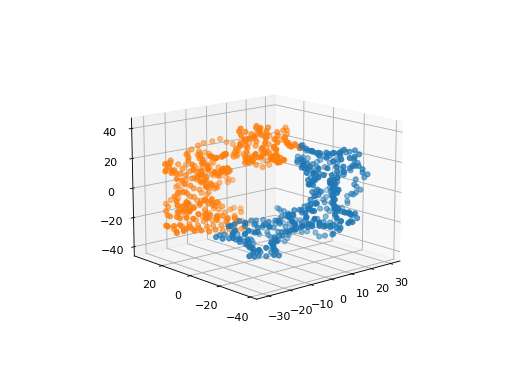

In [19]:
struct.plot_frame(0)

In [20]:
%matplotlib inline

In this specific case it is possible to skip the `compose_database` command, since we only have 1 frame, that has already been read. I will put it here anyway, to have a complete workflow.


In [21]:
struct.compose_database()

sampling_interval CAN NOT be more than 1 .
 sampling_interval is:  1


We can nowperform the analysis, and collect the data.

In [22]:
struct.analyze_inLoop()

processing started...

Analyzing frame n°  0
Time to compute distance is:  0.012402840999129694 seconds.


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Time to denoise:  0.8908350099954987 seconds.
Finished analysis of frame n° 0
Time needed to analyze frame 0 was 0.930867 seconds.

Total time to analyze dataset was 0.930898 seconds
.


In [23]:
struct.get_data()

In [24]:
struct.database

,n° of peptides in macroaggregates,parallel,antiparallel,n° of macroaggreates,0
0,[2],0,1,1,"{'parallel': 0, 'antiparallel': 1}"


At this point we have ran our standard workflow. We can now perform additional analysis, to study the alpha-helix structures.

## Alpha helix

To perform the analysis we need one additional command.

In [27]:
struct.helix_score()

When the analysis ends, we will have a pandas.DataFrame for each frame (only one in this case), with the output of the analysis.

In [28]:
struct.frames[0].results.helix_score

,pace_helix,n_carbonalpha,perc_alpha,length_beta,n_carbonbeta,perc_beta,explored_alpha,explored_beta
0,4.010985,90,24.590164,9.022447,92,25.136612,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...","[42, 52, 55, 56, 57, 58, 63, 64, 65, 66, 67, 6..."
1,3.989136,90,24.590164,9.0235,88,24.043716,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20,...","[42, 52, 56, 57, 58, 63, 65, 66, 67, 68, 70, 7..."


Each row of the above database refer, in this case, to a subunit of the the beta-clamp dimer.

Here we focus on one of the output that we just obtained: ***explored_alpha***.

*explored_alpha* contains the index of the residues that partecipate in an alpha-helical secondary structure, as found from `morphoscanner` searching algorithm.

We use the following code to get the indices, and to transform it in a suitable format to be retrived from `MDAnalysis.Universe`, and then be visualized with `nglview`.

#### convert to string

In [31]:
alpha_str = ' '.join(str(i) for i in struct.frames[0].results.helix_score.explored_alpha[0])

In [32]:
alpha_str

'8 9 10 11 12 13 14 15 16 17 18 19 20 29 30 31 41 51 73 74 75 76 77 78 79 80 81 96 104 114 115 133 134 135 136 137 138 139 140 141 142 144 145 152 154 166 176 199 200 201 202 203 204 205 206 222 245 246 247 251 261 262 263 264 265 266 267 268 269 270 271 272 273 277 289 299 300 322 323 324 325 326 327 328 329 330 331 344 345 354'

#### make it suitable to make a request to `MDAnalysis.Universe`

In [34]:
alpha_call = 'resid ' + alpha_str

In [35]:
alpha_call

'resid 8 9 10 11 12 13 14 15 16 17 18 19 20 29 30 31 41 51 73 74 75 76 77 78 79 80 81 96 104 114 115 133 134 135 136 137 138 139 140 141 142 144 145 152 154 166 176 199 200 201 202 203 204 205 206 222 245 246 247 251 261 262 263 264 265 266 267 268 269 270 271 272 273 277 289 299 300 322 323 324 325 326 327 328 329 330 331 344 345 354'

In [36]:
alpha_atom = struct.universe.select_atoms(alpha_call)

#### Use `nglview` for the visualization

In [42]:
view = nv.show_mdanalysis(alpha_atom)

In [43]:
view

NGLWidget()

#### clean a bit and view again

In [40]:
view.remove_ball_and_stick()
view.add_cartoon()

In [41]:
view

NGLWidget(n_components=1)

We can compare it with the whole protein:

In [44]:
nv.show_pdbid('3bep')

NGLWidget()

## Some utilities that can be useful

`morphoscanner` simplifies the analysis, making it possible with a single command.

What happens under the hood in this case is:
- calculation of the distance map, already done with the first part of the workflow
- calculation of the contact map, with distance based thresholds
- analysis of the contact map

So we get the map:

In [45]:
dmap_sub0 = struct.frames[0].results.distance_maps[0][0]

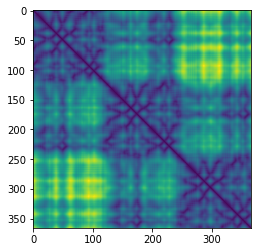

In [46]:
plt.imshow(dmap_sub0)

Calculate the contact map:

In [47]:
h_cont = morphoscanner.backend.helix_recognition.contact_map_helix_torch(dmap_sub0)

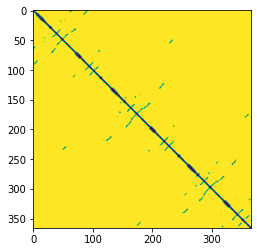

In [48]:
plt.imshow(h_cont)

Perform the pattern recognition:

In [49]:
trace = morphoscanner.backend.helix_recognition.contact_tracer(h_cont)

In [50]:
trace

{'pace_helix': 4.010984864791529,
 'n_carbonalpha': 90,
 'perc_alpha': 24.59016393442623,
 'length_beta': 9.022446574380128,
 'n_carbonbeta': 92,
 'perc_beta': 25.136612021857925,
 'explored_alpha': array([  8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
         29,  30,  31,  41,  51,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  96, 104, 114, 115, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 144, 145, 152, 154, 166, 176, 199, 200, 201, 202, 203,
        204, 205, 206, 222, 245, 246, 247, 251, 261, 262, 263, 264, 265,
        266, 267, 268, 269, 270, 271, 272, 273, 277, 289, 299, 300, 322,
        323, 324, 325, 326, 327, 328, 329, 330, 331, 344, 345, 354],
       dtype=int32),
 'explored_beta': array([ 42,  52,  55,  56,  57,  58,  63,  64,  65,  66,  67,  68,  70,
         71,  85,  87,  88,  89,  91,  97,  99, 106, 107, 108, 109, 110,
        112, 155, 167, 168, 169, 171, 172, 177, 178, 179, 181, 182, 183,
        187, 191, 192, 193, 194, 213, 

And the this becomes the good looking pandas.DataFrame

In [61]:
helix_score_data = pd.DataFrame.from_dict(trace, orient='index').transpose()

In [62]:
helix_score_data

,pace_helix,n_carbonalpha,perc_alpha,length_beta,n_carbonbeta,perc_beta,explored_alpha,explored_beta
0,4.010985,90,24.590164,9.022447,92,25.136612,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...","[42, 52, 55, 56, 57, 58, 63, 64, 65, 66, 67, 6..."
